# 第5章 大規模言語モデルのファインチューニング

## 5.4 自然言語推論・意味的類似度計算・多肢選択式質問応答モデルの実装

### 5.4.1 自然言語推論

#### 環境の準備

In [ ]:
!pip install transformers[ja,torch] datasets matplotlib japanize-matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 65.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 46.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 101.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 114.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 80.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 599.9/599.9 kB 53.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 87.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 MB 10.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 49.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ..

In [ ]:
from transformers.trainer_utils import set_seed

# 乱数シードを42に固定
set_seed(42)

#### データセットの準備

In [ ]:
from pprint import pprint
from datasets import load_dataset

# Hugging Face Hub上のllm-book/JGLUEのリポジトリから
# JNLIのデータを読み込む
train_dataset = load_dataset(
    "llm-book/JGLUE", name="JNLI", split="train"
)
valid_dataset = load_dataset(
    "llm-book/JGLUE", name="JNLI", split="validation"
)
# pprintで見やすく表示する
pprint(train_dataset[0])

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Dataset jglue downloaded and prepared to /root/.cache/huggingface/datasets/llm-book___jglue/JNLI/1.1.0/afed02e914319785e72f3ea981b4bd3e00089f2361b1137820c183c6b8173edd. Subsequent calls will reuse this data.


{'label': 2,
 'sentence1': '二人の男性がジャンボジェット機を見ています。',
 'sentence2': '2人の男性が、白い飛行機を眺めています。',
 'sentence_pair_id': '0',
 'yjcaptions_id': '100124-104404-104405'}


In [ ]:
pprint(train_dataset.features)

{'label': ClassLabel(names=['entailment', 'contradiction', 'neutral'], id=None),
 'sentence1': Value(dtype='string', id=None),
 'sentence2': Value(dtype='string', id=None),
 'sentence_pair_id': Value(dtype='string', id=None),
 'yjcaptions_id': Value(dtype='string', id=None)}


#### トークナイザ

In [ ]:
from transformers import AutoTokenizer

# Hugging Face Hub上のモデル名を指定
model_name = "cl-tohoku/bert-base-japanese-v3"
# モデル名からトークナイザを読み込む
tokenizer = AutoTokenizer.from_pretrained(model_name)

#### データセット統計の可視化

100%|██████████| 20073/20073 [00:11<00:00, 1679.10it/s]


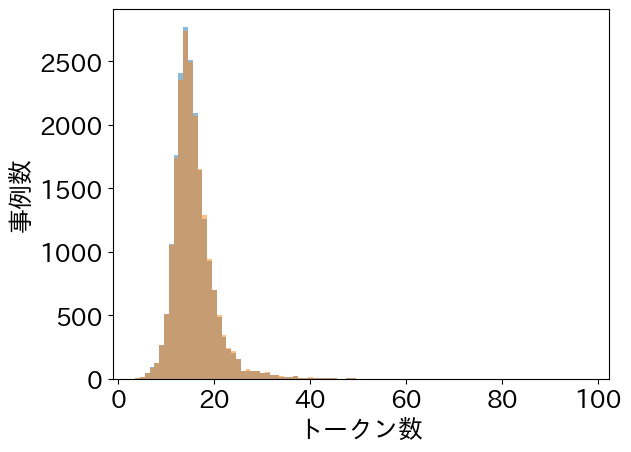

100%|██████████| 2434/2434 [00:01<00:00, 1685.06it/s]


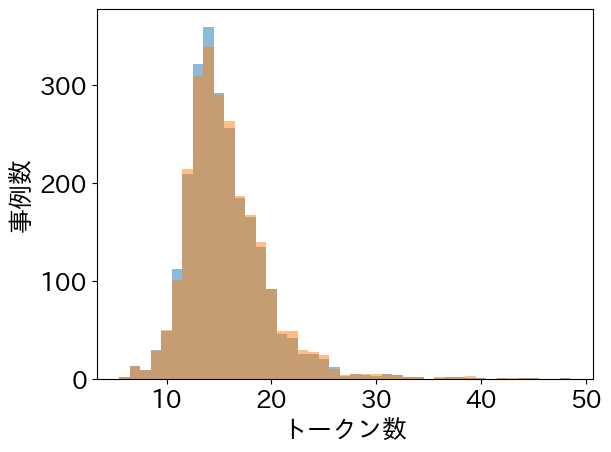

In [ ]:
from collections import Counter
import japanize_matplotlib
import matplotlib.pyplot as plt
from datasets import Dataset
from tqdm import tqdm

plt.rcParams["font.size"] = 18  # 文字サイズを大きくする

def visualize_text_length(dataset: Dataset):
    """データセット中のテキストのトークン数の分布をグラフとして描画"""
    # データセット中のテキストの長さを数える
    length_counter1 = Counter()
    length_counter2 = Counter()
    for data in tqdm(dataset):
        length1 = len(tokenizer.tokenize(data["sentence1"]))
        length_counter1[length1] += 1
        length2 = len(tokenizer.tokenize(data["sentence2"]))
        length_counter2[length2] += 1
    # length_counterの値から棒グラフを描画する
    plt.bar(length_counter1.keys(), length_counter1.values(), width=1.0, alpha=0.5)
    plt.bar(length_counter2.keys(), length_counter2.values(), width=1.0, alpha=0.5)
    plt.xlabel("トークン数")
    plt.ylabel("事例数")
    plt.show()

visualize_text_length(train_dataset)
visualize_text_length(valid_dataset)

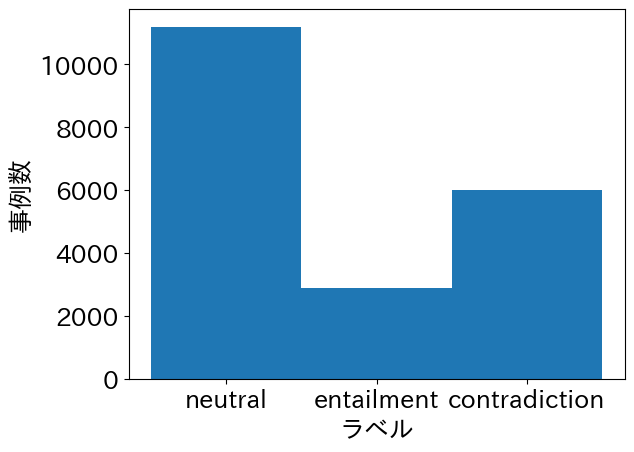

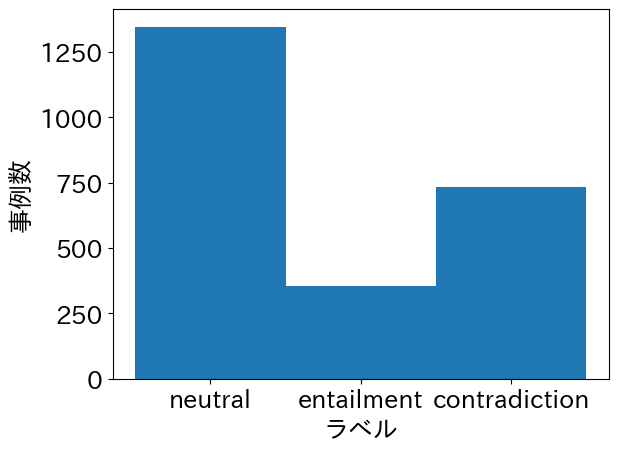

In [ ]:
def visualize_labels(dataset: Dataset):
    """データセット中のラベル分布をグラフとして描画"""
    # データセット中のラベルの数を数える
    label_counter = Counter()
    for data in dataset:
        label_id = data["label"]
        label_name = dataset.features["label"].names[label_id]
        label_counter[label_name] += 1
    # label_counterを棒グラフとして描画する
    plt.bar(label_counter.keys(), label_counter.values(), width=1.0)
    plt.xlabel("ラベル")
    plt.ylabel("事例数")
    plt.show()

visualize_labels(train_dataset)
visualize_labels(valid_dataset)

#### データセットの前処理

In [ ]:
from transformers import BatchEncoding

def preprocess_text_pair_classification(
    example: dict[str, str | int]
) -> BatchEncoding:
    """文ペア関係予測の事例をトークナイズし、IDに変換"""
    # 出力は"input_ids", "token_type_ids", "attention_mask"をkeyとし、
    # list[int]をvalueとするBatchEncodingオブジェクト
    encoded_example = tokenizer(
        example["sentence1"], example["sentence2"], max_length=128
    )

    # 以降で使うモデルのBertForSequenceClassificationのforwardメソッドが
    # 受け取るラベルの引数名に合わせて"labels"をキーにする
    encoded_example["labels"] = example["label"]
    return encoded_example

In [ ]:
encoded_train_dataset = train_dataset.map(
    preprocess_text_pair_classification,
    remove_columns=train_dataset.column_names,
)
encoded_valid_dataset = valid_dataset.map(
    preprocess_text_pair_classification,
    remove_columns=valid_dataset.column_names,
)

Map:   0%|          | 0/20073 [00:00<?, ? examples/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Map:   0%|          | 0/2434 [00:00<?, ? examples/s]

In [ ]:
print(encoded_train_dataset[0])

{'input_ids': [2, 14269, 464, 13341, 430, 27914, 16753, 3107, 500, 5538, 456, 422, 12995, 385, 3, 33, 680, 464, 13341, 430, 384, 16517, 13208, 3107, 500, 29887, 456, 422, 12995, 385, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'labels': 2}


#### ミニバッチ構築

In [ ]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
batch_inputs = data_collator(encoded_train_dataset[0:4])
pprint({name: tensor.size() for name, tensor in batch_inputs.items()})

{'attention_mask': torch.Size([4, 31]),
 'input_ids': torch.Size([4, 31]),
 'labels': torch.Size([4]),
 'token_type_ids': torch.Size([4, 31])}


#### モデルの準備

In [ ]:
from transformers import AutoModelForSequenceClassification

class_label = train_dataset.features["label"]
label2id = {label: id for id, label in enumerate(class_label.names)}
id2label = {id: label for id, label in enumerate(class_label.names)}
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=class_label.num_classes,
    label2id=label2id,  # ラベル名からIDへの対応を指定
    id2label=id2label,  # IDからラベル名への対応を指定
)
print(type(model).__name__)

# パラメータをメモリ上に隣接した形で配置
# これを実行しない場合、モデルの保存でエラーになることがある
for param in model.parameters():
    param.data = param.data.contiguous()

Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-v3 were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification wer

BertForSequenceClassification


In [ ]:
print(model.forward(**data_collator(encoded_train_dataset[0:4])))

SequenceClassifierOutput(loss=tensor(1.3709, grad_fn=<NllLossBackward0>), logits=tensor([[ 0.5438, -0.6999, -0.6652],
        [ 0.5443, -0.6911, -0.6591],
        [ 0.5689, -0.7136, -0.6473],
        [ 0.5303, -0.7133, -0.6069]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)


#### 訓練の実行

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="output_jnli",  # 結果の保存フォルダ
    per_device_train_batch_size=32,  # 訓練時のバッチサイズ
    per_device_eval_batch_size=32,  # 評価時のバッチサイズ
    learning_rate=2e-5,  # 学習率
    lr_scheduler_type="linear",  # 学習率スケジューラの種類
    warmup_ratio=0.1,  # 学習率のウォームアップの長さを指定
    num_train_epochs=3,  # エポック数
    save_strategy="epoch",  # チェックポイントの保存タイミング
    logging_strategy="epoch",  # ロギングのタイミング
    evaluation_strategy="epoch",  # 検証セットによる評価のタイミング
    load_best_model_at_end=True,  # 訓練後に開発セットで最良のモデルをロード
    metric_for_best_model="accuracy",  # 最良のモデルを決定する評価指標
    fp16=True,  # 自動混合精度演算の有効化
    report_to="none",  # 外部ツールへのログを無効化
)

In [ ]:
import numpy as np

def compute_accuracy(
    eval_pred: tuple[np.ndarray, np.ndarray]
) -> dict[str, float]:
    """予測ラベルと正解ラベルから正解率を計算"""
    predictions, labels = eval_pred
    # predictionsは各ラベルについてのスコア
    # 最もスコアの高いインデックスを予測ラベルとする
    predictions = np.argmax(predictions, axis=1)
    return {"accuracy": (predictions == labels).mean()}

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    train_dataset=encoded_train_dataset,
    eval_dataset=encoded_valid_dataset,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_accuracy,
)
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.500700,0.300737,0.889893
2,0.213200,0.316200,0.895234
3,0.123600,0.327583,0.908792


TrainOutput(global_step=1884, training_loss=0.27915608351397664, metrics={'train_runtime': 272.775, 'train_samples_per_second': 220.764, 'train_steps_per_second': 6.907, 'total_flos': 1651171850205822.0, 'train_loss': 0.27915608351397664, 'epoch': 3.0})

#### 訓練後のモデルの評価

In [ ]:
# 検証セットでモデルを評価
eval_metrics = trainer.evaluate(encoded_valid_dataset)
pprint(eval_metrics)

{'epoch': 3.0,
 'eval_accuracy': 0.9087921117502055,
 'eval_loss': 0.32758286595344543,
 'eval_runtime': 2.8536,
 'eval_samples_per_second': 852.967,
 'eval_steps_per_second': 26.984}


#### モデルの保存

Google Driveへの保存

In [ ]:
# Googleドライブをマウントする
from google.colab import drive

drive.mount("drive")

In [ ]:
# 保存されたモデルをGoogleドライブのフォルダにコピーする
!mkdir -p drive/MyDrive/llm-book
!cp -r output_jnli drive/MyDrive/llm-book

Hugging Face Hubへの保存

In [ ]:
from huggingface_hub import login

login()

# Hugging Face Hubのリポジトリ名
# "YOUR-ACCOUNT"は自らのユーザ名に置き換えてください
repo_name = "YOUR-ACCOUNT/bert-base-japanese-v3-jnli"
# トークナイザとモデルをアップロード
tokenizer.push_to_hub(repo_name)
model.push_to_hub(repo_name)